## ResNet101

GPU 확인

In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2022-06-22 09:53:59.326753: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-22 09:54:00.134791: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /device:GPU:0 with 13690 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17373875766114852634
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14355857408
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4061752469452677132
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array,load_img

from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import ResNet101

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import datetime

config 설정

In [3]:
trainImagePath = '../dataSet/splitImages/train'
validationImagePath = '../dataSet/splitImages/val'
testImagePath = '../dataSet/splitImages/test'

checkpointPath = '../test/checkpoints/epoch_{epoch:04d}.h5'
logsPath = '../test/logs/fit/'+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
bestCheckpointPath = '../test/model/epoch_{epoch:04d}.h5'
savedModelPath = '../test/model/resnet101Model.h5'

batchSize = 32
imageWidth = 224
imageHeight = 224
imageChannel = 3
dropRate = 0.3
n_classes = 54


### 이미지 데이터 생성

ImageDataGenerator (train, validation)

In [4]:
trainDataGen = ImageDataGenerator(rescale=1./255,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.2,
                                  zoom_range=-0.3,
                                  horizontal_flip=False,
                                  vertical_flip=False,
                                  brightness_range=[0.7, 1.3],
                                  fill_mode='nearest'
                                  )

train set

In [5]:
trainGenSet = trainDataGen.flow_from_directory(
    trainImagePath,
    batch_size=batchSize,
    target_size=(imageWidth,imageHeight),
    class_mode='categorical',
    shuffle=True
)

Found 7653 images belonging to 54 classes.


validation set

In [6]:
validationGenSet = trainDataGen.flow_from_directory(
    validationImagePath,
    batch_size=batchSize,
    target_size=(imageWidth,imageHeight),
    class_mode='categorical',
)

Found 937 images belonging to 54 classes.


ImageDataGenerator (train, validation)

In [7]:
testDataGen = ImageDataGenerator(rescale=1./255)

test set

In [8]:
testGenSet = testDataGen.flow_from_directory(
    testImagePath,
    batch_size=batchSize,
    target_size=(imageWidth,imageHeight),
    class_mode='categorical'
)

Found 1001 images belonging to 54 classes.


make model

In [9]:
model = tf.keras.Sequential([
  ResNet101(include_top=False, weights='imagenet', input_shape=(imageWidth, imageHeight, imageChannel)),
  GlobalAveragePooling2D(),
  Dropout(rate=dropRate),
  Dense(1024, activation='relu' ),
  Dropout(rate=dropRate),
  Dense(512, activation='relu' ),
  Dropout(rate=dropRate),
  Dense(256, activation='relu' ),
  Dense(n_classes, activation='softmax'),
])

model.summary()

2022-06-22 09:54:01.336551: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13690 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                        

model compile

In [10]:
model.compile(loss='categorical_crossentropy',
             optimizer='sgd',
             metrics=['accuracy'])

difine callbacks

In [11]:
checkpoint = ModelCheckpoint(
                        checkpointPath, monitor='val_loss', verbose=0, save_best_only=False,
                        save_weights_only=False, mode='auto', save_freq='epoch'
                    )


In [12]:
earlyStopping = [
                    EarlyStopping(monitor='val_loss', patience=10, ),
                    ModelCheckpoint( bestCheckpointPath, monitor='val_loss', save_best_only=True )
                ]

In [13]:
tensorboard = tf.keras.callbacks.TensorBoard(logsPath, histogram_freq=1)

model fit

In [14]:
epochs = 200
history = model.fit(
    trainGenSet,
    epochs=epochs,
    validation_data=validationGenSet,
    callbacks=[checkpoint,earlyStopping, tensorboard],
    verbose=1
)

Epoch 1/200


2022-06-22 09:54:22.105301: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8303


240/240 [==============================] - ETA: 0s - loss: 2.5859 - accuracy: 0.3946

2022-06-22 10:05:30.600434: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 566231040 exceeds 10% of free system memory.
2022-06-22 10:05:30.946914: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 503316480 exceeds 10% of free system memory.
2022-06-22 10:05:31.206188: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 251658240 exceeds 10% of free system memory.
2022-06-22 10:05:31.380220: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 251658240 exceeds 10% of free system memory.
2022-06-22 10:05:31.543984: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 566231040 exceeds 10% of free system memory.


240/240 [==============================] - 684s 3s/step - loss: 2.5859 - accuracy: 0.3946 - val_loss: 8.9668 - val_accuracy: 0.0160
Epoch 2/200
240/240 [==============================] - 664s 3s/step - loss: 0.2927 - accuracy: 0.9351 - val_loss: 5.4378 - val_accuracy: 0.0459
Epoch 3/200
240/240 [==============================] - 661s 3s/step - loss: 0.0786 - accuracy: 0.9831 - val_loss: 1.5281 - val_accuracy: 0.6297
Epoch 4/200
240/240 [==============================] - 645s 3s/step - loss: 0.0388 - accuracy: 0.9920 - val_loss: 0.0661 - val_accuracy: 0.9819
Epoch 5/200
240/240 [==============================] - 641s 3s/step - loss: 0.0241 - accuracy: 0.9956 - val_loss: 0.0066 - val_accuracy: 0.9989
Epoch 6/200
240/240 [==============================] - 669s 3s/step - loss: 0.0152 - accuracy: 0.9978 - val_loss: 7.0020e-04 - val_accuracy: 1.0000
Epoch 7/200
240/240 [==============================] - 643s 3s/step - loss: 0.0124 - accuracy: 0.9978 - val_loss: 3.3158e-04 - val_accuracy: 1.0

In [31]:
testLoss, testAccuracy = model.evaluate(testGenSet, verbose=1)

print("test_loss:", round(testLoss, 5), "test_accuracy:", testAccuracy)

32/32 [==============================] - 76s 2s/step - loss: 9.0716e-07 - accuracy: 1.0000
test_loss: 0.0 test_accuracy: 1.0


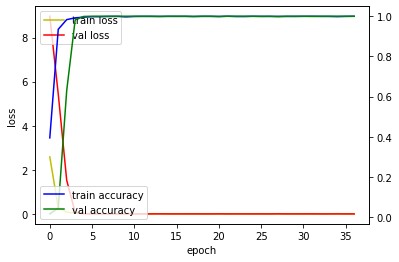

In [16]:


fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label = 'train loss')
loss_ax.plot(history.history['val_loss'], 'r', label = 'val loss')
acc_ax.plot(history.history['accuracy'], 'b', label = 'train accuracy')
acc_ax.plot(history.history['val_accuracy'], 'g', label = 'val accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_xlabel('accuracy')

loss_ax.legend(loc = 'upper left')
acc_ax.legend(loc = 'lower left')

plt.show()

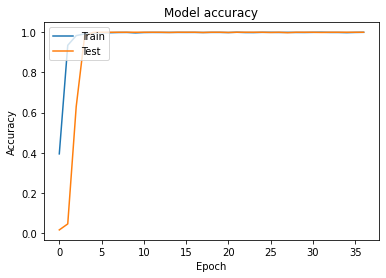

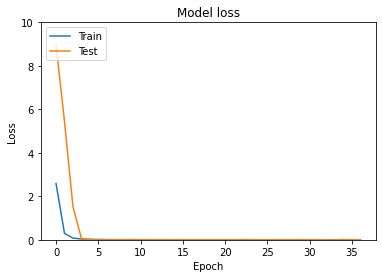

In [17]:
# 6 훈련 과정 시각화 (정확도)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# 7 훈련 과정 시각화 (손실)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 10])
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [18]:
model.save(savedModelPath)

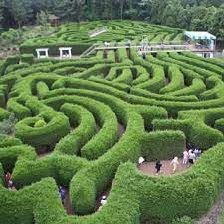

In [19]:
testImage = load_img("../testImage.jpg", target_size = (imageHeight, imageWidth))
testImage

In [20]:
testImage = img_to_array(testImage)
testImage = testImage/255.0

print(testImage.shape)

(224, 224, 3)


In [21]:
confidence = model.predict(testImage.reshape((1, imageHeight, imageWidth, imageChannel)))

1/1 [==============================] - 2s 2s/step


In [22]:
for i in range(confidence.shape[1]):
    print(f"{i} 일 확률 = {round(confidence[0][i], 3)}")

print(f"정답은 : {np.argmax(confidence, axis=1)}")

0 일 확률 = 0.0
1 일 확률 = 0.0
2 일 확률 = 0.0
3 일 확률 = 0.0
4 일 확률 = 1.0
5 일 확률 = 0.0
6 일 확률 = 0.0
7 일 확률 = 0.0
8 일 확률 = 0.0
9 일 확률 = 0.0
10 일 확률 = 0.0
11 일 확률 = 0.0
12 일 확률 = 0.0
13 일 확률 = 0.0
14 일 확률 = 0.0
15 일 확률 = 0.0
16 일 확률 = 0.0
17 일 확률 = 0.0
18 일 확률 = 0.0
19 일 확률 = 0.0
20 일 확률 = 0.0
21 일 확률 = 0.0
22 일 확률 = 0.0
23 일 확률 = 0.0
24 일 확률 = 0.0
25 일 확률 = 0.0
26 일 확률 = 0.0
27 일 확률 = 0.0
28 일 확률 = 0.0
29 일 확률 = 0.0
30 일 확률 = 0.0
31 일 확률 = 0.0
32 일 확률 = 0.0
33 일 확률 = 0.0
34 일 확률 = 0.0
35 일 확률 = 0.0
36 일 확률 = 0.0
37 일 확률 = 0.0
38 일 확률 = 0.0
39 일 확률 = 0.0
40 일 확률 = 0.0
41 일 확률 = 0.0
42 일 확률 = 0.0
43 일 확률 = 0.0
44 일 확률 = 0.0
45 일 확률 = 0.0
46 일 확률 = 0.0
47 일 확률 = 0.0
48 일 확률 = 0.0
49 일 확률 = 0.0
50 일 확률 = 0.0
51 일 확률 = 0.0
52 일 확률 = 0.0
53 일 확률 = 0.0
정답은 : [4]


In [29]:
dfTrain = pd.read_csv('../back/categoryList.csv', encoding='cp949')
dfTrain.head()

,categoryNumber,categoryName
0,0,감귤박물관
1,1,검멀레동굴
2,2,관덕정
3,3,구엄리돌염전
4,4,김녕미로공원


In [30]:
dfTrain['categoryName'].unique()[np.argmax(confidence, axis=1)][0]

'김녕미로공원'